In [1]:
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [34]:
train_csv = 'seg_train.csv'
test_csv = 'seg_test.csv'

In [51]:
class SceneData(Dataset):
    
    def __init__(self, csv_dir, transform = None):
        
        self.data_csv = pd.read_csv(csv_dir)
        self.label_dict = {'buildings': 0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
        self.transform = transform
        
    def __len__(self):
        return len(self.data_csv)
    
    def __getitem__(self, idx):
        
        img = cv2.imread(self.data_csv['img_loc'][idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        label = self.data_csv['img_label'][idx]
        label = self.label_dict[label]
        
        
        sample = {'image': img, 'label': label}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

In [52]:
tfs=transforms.ToTensor()
#train_dir
trainset=SceneData(train_csv, tfs)
#test_dir
testset=SceneData(test_csv, tfs)


0


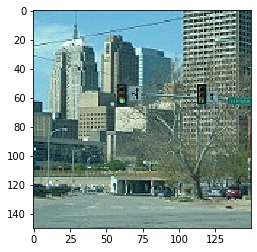

In [53]:
#example of testing image
sample=testset[1]
plt.imshow(sample['image'].numpy().transpose(1,2,0))
print(sample['label'])

In [54]:
#dataloader
trainloader=DataLoader(trainset, batch_size=15)
testloader=DataLoader(testset, batch_size=15)

In [55]:
#image viewer
#fucntion call eg: imshow(testset[1])
def imshow(img):
    sample=img
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    print(sample['label'])
    print(sample['image'].shape)

0
torch.Size([3, 150, 150])


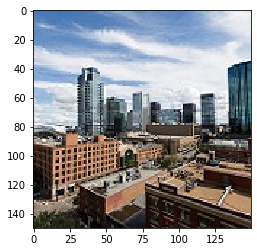

In [56]:
imshow(trainset[1])

In [2]:
#defining Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #Input Tensor(150x150x3) ---> 73x73x16
        self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5)  
        #dont add padding, padding will increase img size, padding =2 will increase size by +4 i.e 154
        #by default stride is of 1.
        
        #NOTE: Try to avoid getting odd size output from neural net
        # 73x73x16 --> 70x70x32
        self.conv2=nn.Conv2d(16,32,4)    #note Ive changed kernal size to 4. Reason you need to find out
        
        #max pooling (2,2)
        #35x35x32 --> 32x32x64
        self.conv3=nn.Conv2d(32,64,4)
        
        #Dont use max pooling of 5x5 u'll lose lot of information
        #max pool of 2x2
        
        #Linear Layer(16x16x64)
        self.fc1=nn.Linear(16*16*64,1500)
        self.fc2=nn.Linear(1500,400)
        self.fc3=nn.Linear(400,6)
        
        #MaxPool Layers
        self.pool=nn.MaxPool2d(2,2)
        #self.pool2=nn.MaxPool2d(5,5)
        
        #Linear Layer()
    def forward(self,x):
        #Convolution and MaxPool layers
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        
        #flattenning image
        x=x.view(-1,64*16*16)
        
        #x = self.dropout(x)  You didnt even defined the dropout layer!!!!
        
        #1st hidden layer, wit ReLu
        x=F.relu(self.fc1(x))
        #x = self.dropout(x)
        x=F.relu(self.fc2(x))
        #x = self.dropout(x)
        x=F.log_softmax(self.fc3(x),dim=1)
        
        return x


In [3]:
#testing script for random inputs.

t1 = torch.randn(1, 3, 150, 150)
# Remember Torch model always take input in 
# Batch_size x Channels x height x width

#initialize model
net = Net()

#change model to evaluation/test mode
net.eval()

out = net(t1)

print(out.shape)


torch.Size([1, 6])


In [4]:
net=Net()

In [6]:
#Loss Function and Optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [ ]:
num_epochs = 20
loader = ['train': trainloader, 'test': testloader]

#check for cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# iterate over each epoch
for epoch in num_epochs:
    print(f'------'*50)
    print(f'epoch: {epoch+1}')
    
    #var to store loss
    running_loss = 0
    test_loss = 0
    
    for val_ in ['train', 'test']:
        
        # iterate over training and testing data
        for i, data in enumerate(loader[val_]):
            
            images, labels = data
            
            #zero the optimizer
            optimizer.zero_grad()
            
            #move data and model to gpu
            model, images, labels = model.to(device), images.to(device), labels.to(device)
            
            if val_ == 'test':
                #move model to evaluation mode
                model.eval()
                outputs = model(images)
                loss = criterion(output, labels) #calculate loss
                test_loss += loss.items()  #get value from tensor
                #there is no backward call in test mode
                
                if (i%200) == 199:
                    print(f'Test Loss: {test_loss}')
                
            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                
                if (i%200) == 199:
                    print(f' running loss: {running_loss}')
                    
print(f'training finished..........')
                
            
            
        